In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
import tqdm
from multiprocess import Pool
from pandas import DataFrame as df
from os.path import join
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
dirname = "../abc/beem"
frames_list = [filename for filename in os.listdir(dirname) if filename.endswith(".aig")]
max_pool = 12

        
def process_aig(f):
    os.system("cd ../abc && ./abc -c \"r " + os.path.join("beem", f) + "; dprove\"")
    return f

with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm.tqdm(
            p.imap(process_aig,
                   frames_list),
            total=len(frames_list)
        )
    )

100%|██████████| 687/687 [1:21:22<00:00,  7.11s/it]   


In [13]:
dirname = "../abc/beem"
file_list = [filename for filename in os.listdir(dirname) if filename.endswith(".csv")]
max_pool = 12

def process_file(file):
    x = pd.read_csv(join(dirname, file))
    x = x.drop(x[x.nRef < 0].index)
    return x
    
with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm.tqdm(
            p.imap(process_file,
                   file_list),
            total=len(file_list)
        )
    )
tot = pd.concat(pool_outputs)
tot

100%|██████████| 522/522 [00:00<00:00, 663.28it/s]


,state,nRef
0,0x7fffdc5e4c30,8
1,0x7fffdc5e4b60,6
2,0x7fffdc5e47e0,11
3,0x7fffdc5e4420,33
4,0x7fffdc5e3fb0,17
...,...,...
3585,0x7fffe09ffcb0,2
3586,0x7fffe032cdd0,6
3587,0x7fffe032d4b0,8
3588,0x7fffe0a63190,1


<AxesSubplot:xlabel='nRef', ylabel='Count'>

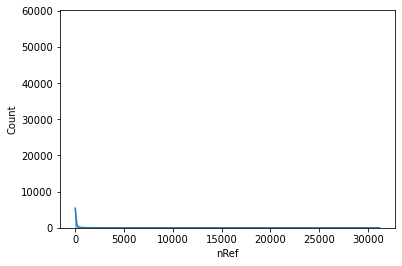

In [15]:
plt.ylim(0, 10000)
sns.histplot(data=tot, x="nRef", kde=True)

In [ ]:
dirname = "../abc/beem"
file_list = [filename for filename in os.listdir(dirname) if filename.endswith(".csv")]
max_pool = 12

#def process_file(file):
#    x = pd.read_csv(join(dirname, file))['cube']
#    normalized_df=(x-x.min())/(x.max()-x.min())
#    return normalized_df.kurt()

def process_file

with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm.tqdm(
            p.imap(process_file,
                   file_list),
            total=len(file_list)
        )
    )
pool_outputs
sns.displot([out for out in pool_outputs if out < 500])